In [1]:
import sys
sys.path.append("../src")
from utils import *

In [ ]:
import matplotlib
from matplotlib import font_manager
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

matplotlib.pyplot.rcParams['font.family'] = "arial"    

In [2]:
datadir

'../data'

In [3]:
sample_sheet = pd.read_csv(os.path.join(datadir, "cohort_overview.csv"), index_col=0)

In [4]:
sample_sheet = sample_sheet[sample_sheet.ustekinumab=="no"]
sample_sheet = sample_sheet[sample_sheet.discard=="no"]

In [5]:
visium_samples = list(set(sample_sheet.Visium_sample_name.dropna().tolist()))

In [6]:
len(visium_samples)

20

In [7]:
# visium_samples

In [8]:
p="/data/projects/robin/ANCA/ctrls_data_reSeq/"
internal_ctrl_samples = [os.path.join(p, file) for file in os.listdir(p) if "." not in file]

In [9]:
all_samples = internal_ctrl_samples

In [10]:
rel_metrics_path="outs/metrics_summary.csv"
for sample in all_samples:
    if sample==all_samples[0]:
        df_metrics = pd.read_csv(os.path.join(sample, rel_metrics_path), index_col=0)
    else:
        tmp = pd.read_csv(os.path.join(sample, rel_metrics_path), index_col=0)
        df_metrics = pd.concat([df_metrics, tmp], axis=0)

In [11]:
df_metrics.to_csv(os.path.join(datadir, "internal_ctrl_samples_metrics.csv"))

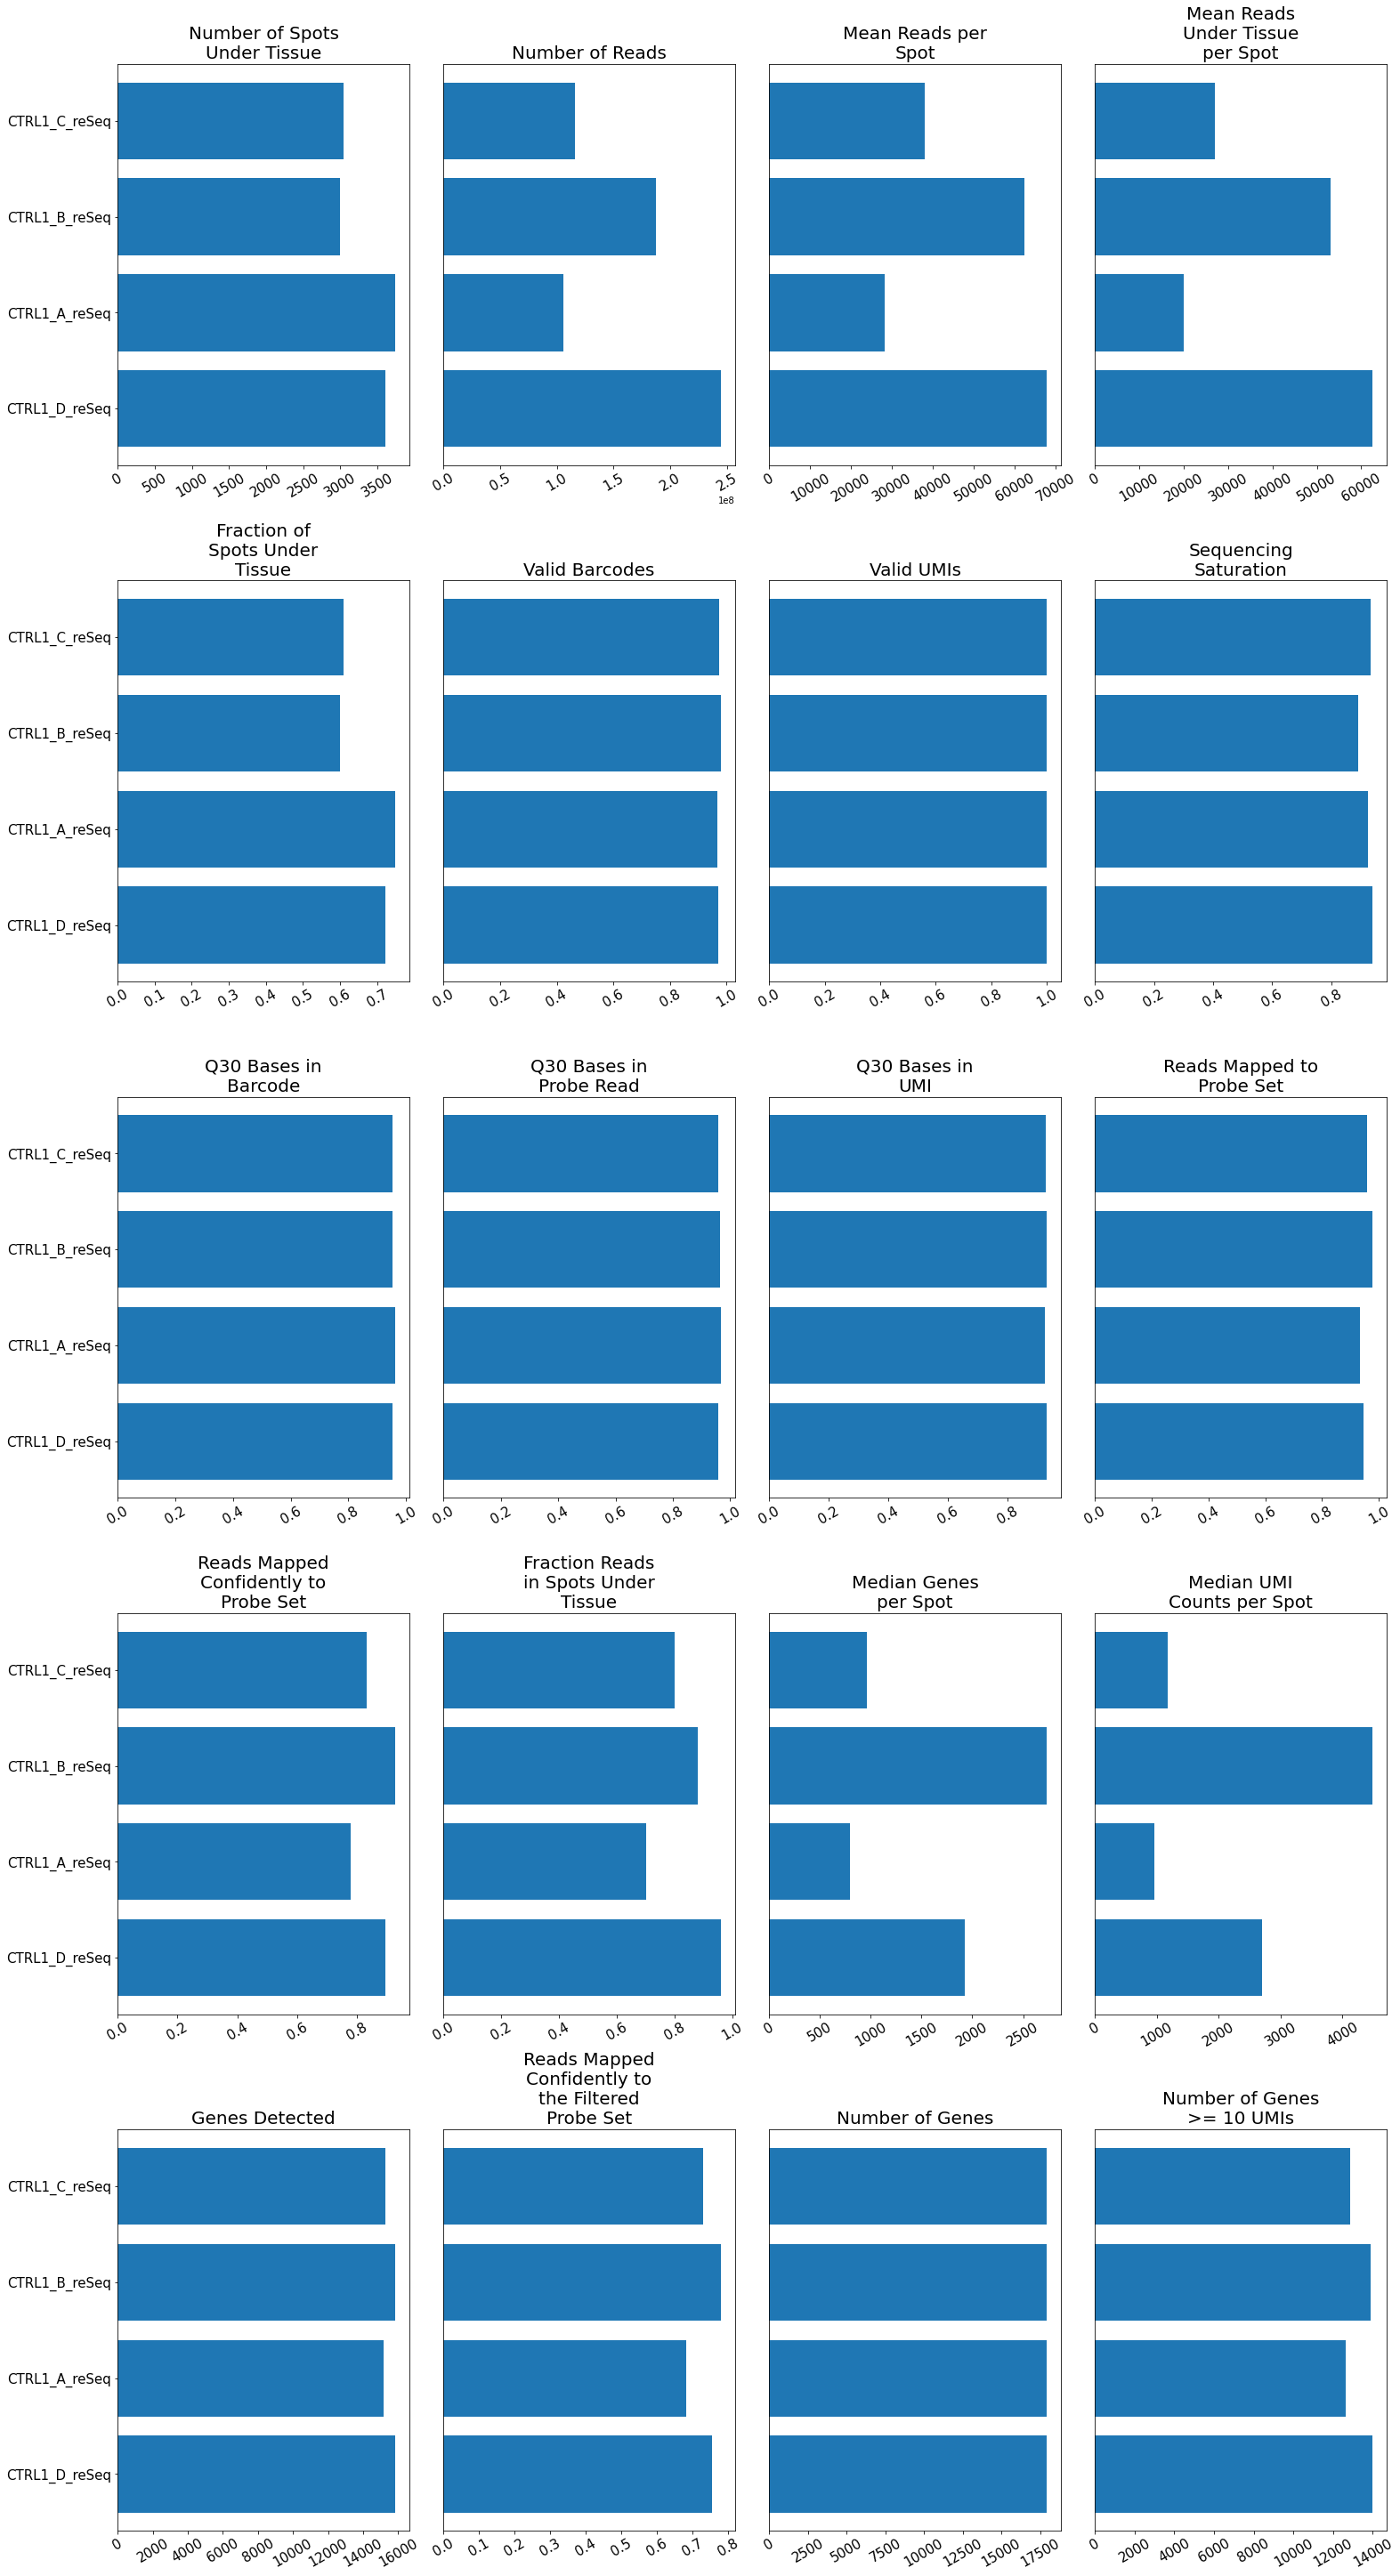

In [12]:
chartQC(df_metrics, show=True, savepath=os.path.join(figdir, "internal_ctrl_samples_metrics_summary.pdf"))

In [13]:
rm_samples = ["/data/projects/ANCA_Atlas/Visum/alignment_Visium_FFPE/V4_A"]
batch_key="Sample"

In [14]:
import warnings
warnings.filterwarnings("ignore") # ignore printing many UserWarning produced during reading multiple anndata (var names not unique etc.)

In [15]:
all_samples = list(set(all_samples))

In [16]:
from tqdm import tqdm

In [17]:
i=0
for sample in tqdm(all_samples):
    if sample not in rm_samples:
        if "_filtered" not in sample:
            tmp = read_visium(os.path.join(sample, "outs"))
        # else:
        #     tmp = sc.read_10x_h5(sample)
            tmp.var_names_make_unique()
            sample_name = sample.split("/")[-1].split(".")[0].split("_filtered")[0]
            tmp.obs[batch_key] = sample_name
            sample = sample_name
            tmp.obs.index = [idx+"_{}".format(sample_name) for idx in tmp.obs.index]
            if i==0:
                adata = tmp
                i=1
            else:
                adata = adata.concatenate(tmp, uns_merge="unique", index_unique=None)

adata.obs = adata.obs[[col for col in adata.obs.columns if col!="batch"]]

100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


In [18]:
adata.raw = adata.copy()

In [19]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], 
                                                                adata.obs.Sample.unique().shape[0])

'No. of spots: 13395, No. of genes: 17943, No. of samples: 4'

In [20]:
target_sum=1e4
min_genes=100
min_spots=3
n_comps=50
n_neighbors=10
use_highly_variable=True
mt_cutoff=20
min_counts=500
max_counts=35000

In [21]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

<AxesSubplot:xlabel='n_genes_by_counts'>

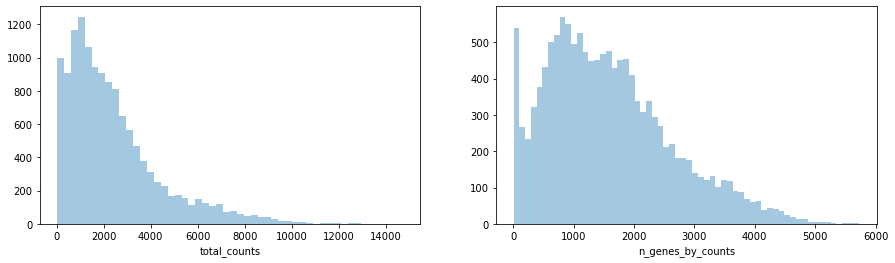

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])


In [23]:
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)
# sc.pp.filter_genes(adata, min_cells=min_spots)

In [24]:
"No. of spots: {}, No. of genes: {}, No. of samples: {}".format(adata.shape[0], adata.shape[1], 
                                                                adata.obs.Sample.unique().shape[0])

'No. of spots: 11827, No. of genes: 17943, No. of samples: 4'

<AxesSubplot:xlabel='n_genes_by_counts'>

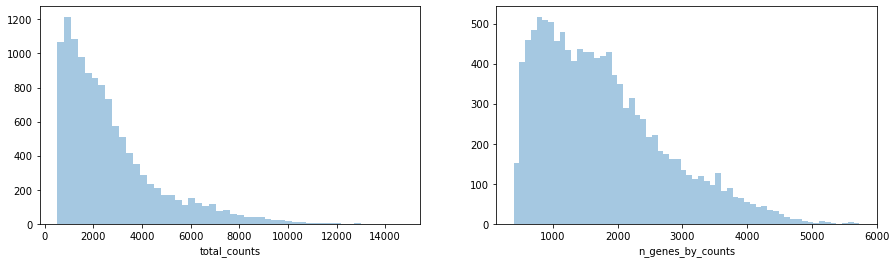

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])


In [26]:
adata.obs["Condition"] = "CTRL"

In [27]:
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

In [28]:
sc.pp.highly_variable_genes(adata, batch_key="Sample")

In [29]:
sc.tl.pca(adata, random_state=seed, use_highly_variable=True, n_comps=50)

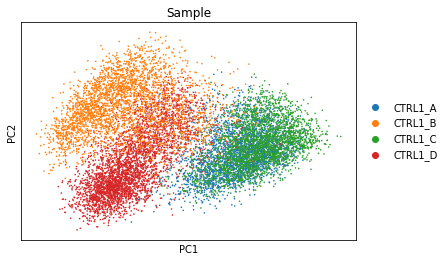

In [30]:
sc.pl.pca(adata, color="Sample")

In [33]:
adata_1 = adata[adata.obs["Sample"]=="CTRL1_A"]
sc.tl.pca(adata_1, use_highly_variable=True, n_comps=50)
sc.pp.neighbors(adata_1, n_neighbors=20, n_pcs= 50)
sc.tl.umap(adata_1)

In [35]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs= 50)
sc.tl.umap(adata)

In [36]:
adata.write(os.path.join(datadir, "internal_ctrl_samples_processed.h5ad"))

In [34]:
adata_1.write(os.path.join(datadir, "CTRL1_A_processed.h5ad"))

In [ ]:
""